## Observations and Insights 

The analysis below reveals the following 4 insights:
1. The two drug regimens with the greatest number of recorded measures also appear to be associated with the lowest average tumor volume in the study mice.
2. The overall sex distribution of the study mice is roughly equal. So long as this distribution does not differ when measured by drug regimen, it appears sex is not a significant factor in explaining tumor volume.
3. Capomulin-treated mice appear to demonstrate a correlation between weight and average tumor volume. It is unclear from the analysis whether this finding holds for other drug regimens. If so, weight could potentially be a significant factor in explaining tumor volume.
4. The mice treated with the 4 most promising drug regimens only have one tumor volume outlier. This suggests that tumor volumes are fairly closely clustered around the mean and, therefore, other outside variables may be relatively less significant in explaining tumor volume.

# Import Files

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as st
import os
from scipy.stats import linregress

# Establish data file paths
mouse_metadata_path = os.path.join("..", "Resources", "Mouse_metadata.csv")
study_results_path = os.path.join("..", "Resources", "Study_results.csv")

# Read the mouse data and the study results as df's
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Mouse Metadata File

In [2]:
# View mouse metadata df
mouse_metadata.head()

Mouse ID Drug Regimen     Sex  Age_months  Weight (g)
0     k403     Ramicane    Male          21          16
1     s185    Capomulin  Female           3          17
2     x401    Capomulin  Female          16          15
3     m601    Capomulin    Male          22          17
4     g791     Ramicane    Male          11          16

In [3]:
# Understand df structure - count rows in table
mouse_metadata.count()

Mouse ID        249
Drug Regimen    249
Sex             249
Age_months      249
Weight (g)      249
dtype: int64

In [4]:
# Understand df structure - count unique mouse ID values
len(pd.unique(mouse_metadata["Mouse ID"]))

# df contains one row per mouse - total of 249 mice in study

249

# Study Results File

In [5]:
# View study results df
study_results.head()

Mouse ID  Timepoint  Tumor Volume (mm3)  Metastatic Sites
0     b128          0                45.0                 0
1     f932          0                45.0                 0
2     g107          0                45.0                 0
3     a457          0                45.0                 0
4     c819          0                45.0                 0

In [6]:
# Understand df structure - count rows in table
study_results.count()

Mouse ID              1893
Timepoint             1893
Tumor Volume (mm3)    1893
Metastatic Sites      1893
dtype: int64

In [7]:
# Understand df structure - count unique mouse ID and timepoint values
len(pd.unique(study_results["Mouse ID"]))
len(pd.unique(study_results["Timepoint"]))

# df contains multiple rows per mouse, 10 unique timepoint values

10

In [8]:
# List the unique timepoints
study_results["Timepoint"].unique()

# Data is recorded for the mice every 5 days

array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45])

## Clean Study Results File

In [9]:
# Remove mice with duplicate timepoints
# Create a new df sorted by mouse ID, then timepoint
sort_study_results = study_results.sort_values(by=['Mouse ID', 'Timepoint'], ascending=[True, True])

# Preview sorted df to ensure sorting worked as expected
sort_study_results.head()

Mouse ID  Timepoint  Tumor Volume (mm3)  Metastatic Sites
113      a203          0           45.000000                 0
389      a203          5           48.508468                 0
598      a203         10           51.852437                 1
758      a203         15           52.777870                 1
1018     a203         20           55.173336                 1

In [10]:
# Create empty list to hold mouse IDs that have duplicate timepoints
drop_rows = []

# Loop through sorted df to pull mouse IDs into list for which duplicate timepoints exist
for x in range(0, len(sort_study_results)):
    if (sort_study_results.iloc[x, 0] == sort_study_results.iloc[x-1, 0]) & (sort_study_results.iloc[x, 1] == sort_study_results.iloc[x-1, 1]):
        drop_rows.append(sort_study_results.iloc[x, 0])

# Print list to see list of mouse IDs with duplicate timepoints
drop_rows

['g989', 'g989', 'g989', 'g989', 'g989']

In [11]:
# Create a new list with only unique mouse IDs from the drop list
unique_drop_rows_set = set(drop_rows)
unique_drop_rows = (list(unique_drop_rows_set))
unique_drop_rows

['g989']

In [12]:
# Drop rows for any mouse ID contained in the drop list
for value in unique_drop_rows:
    study_results.drop(study_results[study_results['Mouse ID'] == value].index, inplace = True)

# Print clean df
study_results.count()

# df appears to either contain 188 mice with full timepoint data or more mice (up to 248) with incomplete timepoint data

Mouse ID              1880
Timepoint             1880
Tumor Volume (mm3)    1880
Metastatic Sites      1880
dtype: int64

# Create Combined Dataframe

In [13]:
# Combine the data into a single dataset
merge_df = pd.merge(mouse_metadata, study_results, how="right", on=["Mouse ID"])

# Display the data table for preview
merge_df.head()

Mouse ID Drug Regimen     Sex  Age_months  Weight (g)  Timepoint  \
0     b128    Capomulin  Female           9          22          0   
1     b128    Capomulin  Female           9          22          5   
2     b128    Capomulin  Female           9          22         10   
3     b128    Capomulin  Female           9          22         15   
4     b128    Capomulin  Female           9          22         20   

   Tumor Volume (mm3)  Metastatic Sites  
0           45.000000                 0  
1           45.651331                 0  
2           43.270852                 0  
3           43.784893                 0  
4           42.731552                 0

In [14]:
# Verify number of rows in merged df equals that in study results df
merge_df.count()

Mouse ID              1880
Drug Regimen          1880
Sex                   1880
Age_months            1880
Weight (g)            1880
Timepoint             1880
Tumor Volume (mm3)    1880
Metastatic Sites      1880
dtype: int64

In [15]:
# Check number of mice in merged df
len(pd.unique(merge_df["Mouse ID"]))

248

# Summary Statistics for Tumor Volume

## Using Stats Functions

In [16]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen (groupby)
regimen_mean = merge_df.groupby(['Drug Regimen'])["Tumor Volume (mm3)"].mean()
regimen_median = merge_df.groupby(['Drug Regimen'])["Tumor Volume (mm3)"].median()
regimen_var = merge_df.groupby(['Drug Regimen'])["Tumor Volume (mm3)"].var()
regimen_std = merge_df.groupby(['Drug Regimen'])["Tumor Volume (mm3)"].std()
regimen_sem = merge_df.groupby(['Drug Regimen'])["Tumor Volume (mm3)"].sem()

summary_tumor_df = pd.DataFrame({"Average Tumor Volume (mm3)": regimen_mean,
                                  "Median Tumor Volume (mm3)": regimen_median,
                                  "Variance of Tumor Volume (mm3)": regimen_var,
                                  "Standard Dev of Tumor Volume (mm3)": regimen_std,
                                  "Standard Error of the Mean of Tumor Volume (mm3)": regimen_sem})

# Display summary table
summary_tumor_df

Average Tumor Volume (mm3)  Median Tumor Volume (mm3)  \
Drug Regimen                                                          
Capomulin                      40.675741                  41.557809   
Ceftamin                       52.591172                  51.776157   
Infubinol                      52.884795                  51.820584   
Ketapril                       55.235638                  53.698743   
Naftisol                       54.331565                  52.509285   
Placebo                        54.033581                  52.288934   
Propriva                       52.320930                  50.446266   
Ramicane                       40.216745                  40.673236   
Stelasyn                       54.233149                  52.431737   
Zoniferol                      53.236507                  51.818479   

              Variance of Tumor Volume (mm3)  \
Drug Regimen                                   
Capomulin                          24.947764   
Ceftamin                           39.290177   
Infubinol                          43.128684   
Ketapril                           68.553577   
Naftisol                           66.173479   
Placebo                            61.168083   
Propriva                           43.852013   
Ramicane                           23.486704   
Stelasyn                           59.450562   
Zoniferol                          48.533355   

              Standard Dev of Tumor Volume (mm3)  \
Drug Regimen                                       
Capomulin                               4.994774   
Ceftamin                                6.268188   
Infubinol                               6.567243   
Ketapril                                8.279709   
Naftisol                                8.134708   
Placebo                                 7.821003   
Propriva                                6.622085   
Ramicane                                4.846308   
Stelasyn                                7.710419   
Zoniferol                               6.966589   

              Standard Error of the Mean of Tumor Volume (mm3)  
Drug Regimen                                                    
Capomulin                                             0.329346  
Ceftamin                                              0.469821  
Infubinol                                             0.492236  
Ketapril                                              0.603860  
Naftisol                                              0.596466  
Placebo                                               0.581331  
Propriva                                              0.544332  
Ramicane                                              0.320955  
Stelasyn                                              0.573111  
Zoniferol                                             0.516398

## Using Aggregate Method

In [17]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen using the aggregation method
regimen_agg = merge_df.groupby(["Drug Regimen"]).agg({"Tumor Volume (mm3)": ["mean", "median", "var", "std", "sem"]})
regimen_agg

Tumor Volume (mm3)                                          
                           mean     median        var       std       sem
Drug Regimen                                                             
Capomulin             40.675741  41.557809  24.947764  4.994774  0.329346
Ceftamin              52.591172  51.776157  39.290177  6.268188  0.469821
Infubinol             52.884795  51.820584  43.128684  6.567243  0.492236
Ketapril              55.235638  53.698743  68.553577  8.279709  0.603860
Naftisol              54.331565  52.509285  66.173479  8.134708  0.596466
Placebo               54.033581  52.288934  61.168083  7.821003  0.581331
Propriva              52.320930  50.446266  43.852013  6.622085  0.544332
Ramicane              40.216745  40.673236  23.486704  4.846308  0.320955
Stelasyn              54.233149  52.431737  59.450562  7.710419  0.573111
Zoniferol             53.236507  51.818479  48.533355  6.966589  0.516398

# Bar and Pie Charts

## Measurement Count by Drug Regimen (Pandas)

In [18]:
# Generate a bar plot showing the total number of measurements taken on each drug regimen using pandas.

# Create a count series by regimen
regimen_measure_count = merge_df.groupby(['Drug Regimen'])["Mouse ID"].count()

# Create df from count series (if needed)
regimen_measure_count_df = pd.DataFrame({"Measurement Count": regimen_measure_count})

# Display count df
regimen_measure_count_df

Measurement Count
Drug Regimen                   
Capomulin                   230
Ceftamin                    178
Infubinol                   178
Ketapril                    188
Naftisol                    186
Placebo                     181
Propriva                    148
Ramicane                    228
Stelasyn                    181
Zoniferol                   182

Text(0.5, 1.0, 'Total Study Measure Count by Drug Regimen')

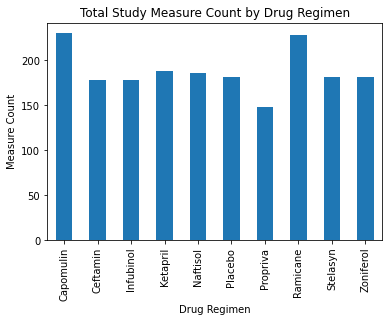

In [19]:
# Create a bar plot using pandas
regimen_count_bar = regimen_measure_count.plot(kind='bar')

# Label y axis and add title
regimen_count_bar.set_ylabel("Measure Count")
regimen_count_bar.set_title("Total Study Measure Count by Drug Regimen")

## Measurement Count by Drug Regimen (Matplotlib)

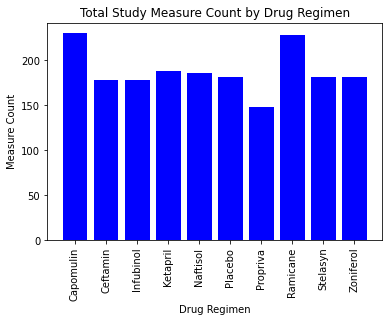

In [20]:
# Generate a bar plot showing the total number of measurements taken on each drug regimen using pyplot.

# Establish x-axis length
x_axis = np.arange(len(regimen_measure_count))

# Create plot with x and y values
plt.bar(x_axis, regimen_measure_count, color="b", align="center")

# Create groupby series from which to pull groupby keys (drug regimens)
regimen_keys = merge_df.groupby(['Drug Regimen'])

# Pull groupby keys
measure_count_keys = regimen_keys.groups.keys()

# Set tick locations, x axis labels as groupby keys and make labels vertical
tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, measure_count_keys, rotation = 90)

# Set chart labels
plt.title("Total Study Measure Count by Drug Regimen")
plt.xlabel("Drug Regimen")
plt.ylabel("Measure Count")

# Display chart
plt.show()

## Mouse Sex (Pandas)

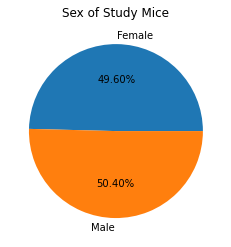

In [21]:
# Generate a pie plot showing the distribution of female versus male mice using pandas

# Drop incomplete mouse from mouse metadata df
for value in unique_drop_rows:
    mouse_metadata.drop(mouse_metadata[mouse_metadata['Mouse ID'] == value].index, inplace = True)

# Create a count series by gender
mouse_sex_count = mouse_metadata.groupby(['Sex'])["Mouse ID"].count()

# Create a pie plot using pandas
sex_count_pie = mouse_sex_count.plot(kind='pie', autopct='%.2f%%')

# Set title and remove default y axis label
sex_count_pie.set_title("Sex of Study Mice")
sex_count_pie.set_ylabel("")

# Display pie chart
plt.show()

## Mouse Sex (Matplotlib)

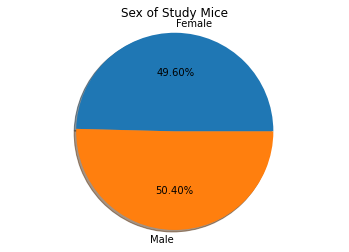

In [22]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot

# Create groupby series from which to pull groupby keys (drug regimens)
sex_keys = mouse_metadata.groupby(['Sex'])

# Pull groupby keys
sex_count_keys = sex_keys.groups.keys()

# Create a pie chart using Matplotlib
plt.pie(mouse_sex_count, labels=sex_count_keys, 
        autopct='%.2f%%', shadow=True)

# Create equal axes for round circle
plt.axis("equal")

# Set title
plt.title("Sex of Study Mice")

# Display the pie chart
plt.show()

# Quartiles, Outliers and Boxplots

In [23]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# THIS INSTRUCTION IS NOT CLEAR - HOW DO WE KNOW THAT A MOUSE COMPLETED THE STUDY IF ITS GREATEST TIMEPOINT IS LESS THAN 45?
# CHOSE TO PROCEED WITH COMMENTED PROMPTS RATHER THAN MY OWN INTERPRETATION OF HOW THIS WOULD BE DONE

# METHOD 1
# Pull final timepoint rows for each drug regimen
# final_promising_cap_df = merge_df.loc[(merge_df["Drug Regimen"] == "Capomulin") & (merge_df["Timepoint"] == 45), :]
# final_promising_ram_df = merge_df.loc[(merge_df["Drug Regimen"] == "Ramicane") & (merge_df["Timepoint"] == 45), :]
# final_promising_inf_df = merge_df.loc[(merge_df["Drug Regimen"] == "Infubinol") & (merge_df["Timepoint"] == 45), :]
# final_promising_cef_df = merge_df.loc[(merge_df["Drug Regimen"] == "Ceftamin") & (merge_df["Timepoint"] == 45), :]

# Concatenate four df's into one
# final_promising_df = pd.concat([final_promising_cap_df, final_promising_ram_df, final_promising_inf_df, final_promising_cef_df], ignore_index=True)

# Eliminate unnecessary columns
# clean_final_promising_df = final_promising_df.loc[:, ["Mouse ID", "Drug Regimen", "Timepoint", "Tumor Volume (mm3)"]]

# METHOD 2
# Pull greatest timepoint for each mouse using max function in .groupby
max_timepoint = merge_df.groupby(['Mouse ID'])["Timepoint"].max()

# Create df from max timepoint series
max_timepoint_df = pd.DataFrame({"Final Timepoint": max_timepoint})

# Merge max timepoint df with the original merged df to match with tumor volume
merge_timepoint_df = pd.merge(max_timepoint_df, merge_df, how="left", left_on=['Mouse ID','Final Timepoint'], right_on = ['Mouse ID','Timepoint'])

# Eliminate unpromising drug regimens
final_promising_df = merge_timepoint_df.loc[(merge_timepoint_df["Drug Regimen"] == "Capomulin") | (merge_timepoint_df["Drug Regimen"] == "Ramicane") | (merge_timepoint_df["Drug Regimen"] == "Infubinol") | (merge_timepoint_df["Drug Regimen"] == "Ceftamin"), :]
final_promising_df

Mouse ID  Final Timepoint Drug Regimen     Sex  Age_months  Weight (g)  \
0       a203               45    Infubinol  Female          20          23   
1       a251               45    Infubinol  Female          21          25   
3       a275               45     Ceftamin  Female          20          28   
6       a411               45     Ramicane    Male           3          22   
7       a444               45     Ramicane  Female          10          25   
..       ...              ...          ...     ...         ...         ...   
238     y769               45     Ceftamin  Female           6          27   
239     y793               45    Capomulin    Male          17          17   
240     y865               45     Ceftamin    Male          23          26   
244     z578               45     Ramicane    Male          11          16   
245     z581               45    Infubinol  Female          24          25   

     Timepoint  Tumor Volume (mm3)  Metastatic Sites  
0           45           67.973419                 2  
1           45           65.525743                 1  
3           45           62.999356                 3  
6           45           38.407618                 1  
7           45           43.047543                 0  
..         ...                 ...               ...  
238         45           68.594745                 4  
239         45           31.896238                 2  
240         45           64.729837                 3  
244         45           30.638696                 0  
245         45           62.754451                 3  

[100 rows x 9 columns]

## Tumor Volume Outliers, Mathematical

In [24]:
# Sort the df containing final timepoints only for promising drug regimens
final_promising_df.sort_values(by='Tumor Volume (mm3)', ascending=True)

# Establish quartiles and interquartile range
quartiles = final_promising_df['Tumor Volume (mm3)'].quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

# Establish upper and lower bounds to find any outliers
lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)

# Print these summary stats for easy viewing
print(f"Lower quartile: {lowerq}")
print(f"Upper quartile: {upperq}")
print(f"Interquartile range: {iqr}")
print(f"Lower bound: {lower_bound}")
print(f"Upper bound: {upper_bound}")

# Find outliers by narrowing df by tumor volume
outlier_df = final_promising_df.loc[(final_promising_df['Tumor Volume (mm3)'] < lower_bound) | (final_promising_df['Tumor Volume (mm3)'] > upper_bound)]
outlier_df

# No outliers in tumor volume appear to be present

Lower quartile: 37.187743802499995
Upper quartile: 59.930261755000004
Interquartile range: 22.74251795250001
Lower bound: 3.0739668737499812
Upper bound: 94.04403868375002


Empty DataFrame
Columns: [Mouse ID, Final Timepoint, Drug Regimen, Sex, Age_months, Weight (g), Timepoint, Tumor Volume (mm3), Metastatic Sites]
Index: []

## Tumor Volume Outliers, Graphical (By Drug Regimen)

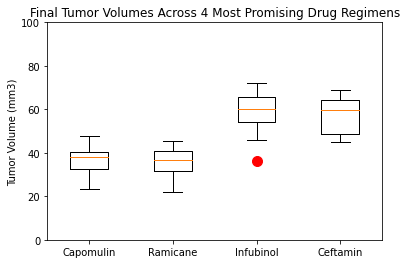

In [25]:
# These instructions are generally very confusing without a visual to support what is meant by the text description.
# The instructions for the mathematical calculation of outliers uses the word "across" regimens.
# So, above, I calculated outliers across regimens.
# However, for the box and whisker plot, it asks for 4 plots (apparently to determine outliers "BY" regimen).
# I'm not sure what is intended so have done the 4 plots but left the mathematical calculation "across" regimens.

# Create list for each drug regimen to hold tumor volumes
cap = []
ram = []
inf = []
cef = []

# Append tumor volumes to each drug regimen list
for index, row in final_promising_df.iterrows():
    if row["Drug Regimen"] == "Capomulin":
        cap.append(row["Tumor Volume (mm3)"])
    if row["Drug Regimen"] == "Ramicane":
        ram.append(row["Tumor Volume (mm3)"])
    if row["Drug Regimen"] == "Infubinol":
        inf.append(row["Tumor Volume (mm3)"])
    if row["Drug Regimen"] == "Ceftamin":
        cef.append(row["Tumor Volume (mm3)"])
    
# Sort the drug regimen tumor volume lists
cap.sort()
ram.sort()
inf.sort()
cef.sort()

# Format the appearance of outlier circles on the plot
flierprops = dict(marker='o', markerfacecolor='red', markersize=10,
                  markeredgecolor='red')

# Assign drug regimen labels to plot rather than numerical values
tick_locations = [1, 2, 3, 4]
boxplot_labels = ["Capomulin", "Ramicane", "Infubinol", "Ceftamin"]

# Create the graph with all 4 plots
data = [cap, ram, inf, cef]
fig1, ax1 = plt.subplots()
ax1.set_title('Final Tumor Volumes Across 4 Most Promising Drug Regimens')
ax1.set_ylabel('Tumor Volume (mm3)')
ax1.boxplot(data, flierprops=flierprops)
plt.xticks(tick_locations, boxplot_labels)
plt.ylim(0, 100)
plt.show()

# When calculating outliers by regimen rather than across regiments, it appears Infubinol contains an outlier

# Line and Scatter Plots

## Selected Capomulin Mouse Tumor Progression

In [26]:
# Pull the ID of the first mouse in the table treated with Capomulin
for index, row in merge_df.iterrows():
    if row["Drug Regimen"] == "Capomulin":
        selected_mouse = row["Mouse ID"]
    break

# Narrow df to contain only the selected mouse
cap_mouse_df = merge_df.loc[(merge_df["Mouse ID"] == selected_mouse), :]

# Create lists from the selected mouse's timepoint and tumor volume data
cap_mouse_timepoint = cap_mouse_df["Timepoint"]
cap_mouse_tumor_vol = cap_mouse_df["Tumor Volume (mm3)"]

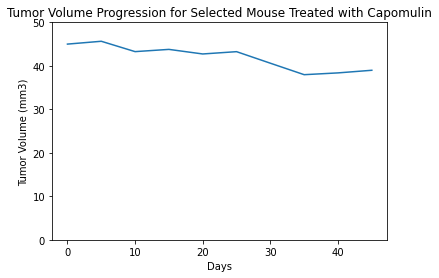

In [27]:
# Plot the selected mouse's tumor volume progression on a line chart
plt.plot(cap_mouse_timepoint, cap_mouse_tumor_vol)
plt.title("Tumor Volume Progression for Selected Mouse Treated with Capomulin")
plt.xlabel("Days")
plt.ylabel("Tumor Volume (mm3)")
plt.ylim(0, 50)

# Display the chart
plt.show()

## Average Tumor Volume versus Weight for Capomulin-Treated Mice

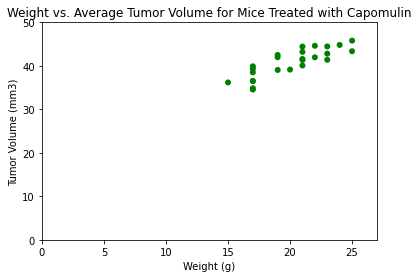

In [28]:
# Pull mice rows treated with Capomulin
full_cap_df = merge_df.loc[(merge_df["Drug Regimen"] == "Capomulin"), :]

# Group by mouse and calculate averages by mouse on all data points
cap_mouse_avg = full_cap_df.groupby(['Mouse ID']).mean()

# Pull averages by mouse for weight and tumor volume
cap_mouse_avg_weight = cap_mouse_avg["Weight (g)"]
cap_mouse_avg_tumor = cap_mouse_avg["Tumor Volume (mm3)"]

# Create scatter plot comparing the two stats
plt.scatter(cap_mouse_avg_weight, cap_mouse_avg_tumor, marker="o", facecolors="green", edgecolors="none")
plt.title("Weight vs. Average Tumor Volume for Mice Treated with Capomulin")
plt.xlabel("Weight (g)")
plt.ylabel("Tumor Volume (mm3)")
plt.ylim(0, 50)
plt.xlim(0, 27)

# Display the chart
plt.show()

# Correlation and Regression

## Average Tumor Volume versus Weight for Capomulin-Treated Mice

0.841936342469472


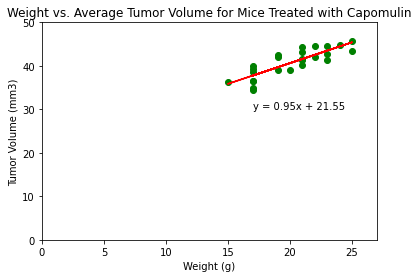

In [29]:
# Calculate correlation/regression values for the weight/tumor volume relationship
(slope, intercept, rvalue, pvalue, stderr) = linregress(cap_mouse_avg_weight, cap_mouse_avg_tumor)

# Print correlation coefficient
print(rvalue)

# Use linear regress eq to solve for y and create printable equation
regress_vals = (cap_mouse_avg_weight * slope) + intercept
lin_equation = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter again
plt.scatter(cap_mouse_avg_weight, cap_mouse_avg_tumor, marker="o", facecolors="green")

# Plot linear regression on scatter plot
plt.plot(cap_mouse_avg_weight, regress_vals, "r-")

# Print equation text on the plot
plt.annotate(lin_equation, (17, 30), fontsize=10, color="black")

# Add title and axis labels and adjust range of axes
plt.title("Weight vs. Average Tumor Volume for Mice Treated with Capomulin")
plt.xlabel('Weight (g)')
plt.ylabel('Tumor Volume (mm3)')
plt.ylim(0, 50)
plt.xlim(0, 27)

# Display chart
plt.show()